---
## Note from the Teachers:
We added a header with information about your project. 
This is useful since we want to keep a database of all the cool projects participants have made during the courses.
We will save the code in our database and host on github a page to show all the projects. Therefore it is more practical to add some information in the header of each notebook.
Thanks a lot for the understanding and for taking care of it.

You can delete this cell if you want

---

# Project Name (replace with your project name)

> Indented block


Project description (replace with your project description, you can use the same from the `INFO.md` file.

### Project Repo 
link (replace if you have your own repo, otherwise delete)

## Participants:
Please list here all the participants alongside with any information you may want to be visible. This will be hosted on a opencampus.sh repository, so if you want to keep a connection to your github user include this information here. 

### Course and Semester
Add here in which course and in which semester it was done.

### License
If you are releasing the software under some certain license, you can mention it and also include the `LICENSE.md` file in the folder

---

### Colab Setup

In [13]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/drive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)

  # Switch to the directory on the Google Drive that you want to use
  import os
  drive_root = mount + "/My Drive/Colab Notebooks/Signal_Denoising_GAN_Project_WS22"
  
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
  
  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
  !pwd

  !pip install -r requirements.txt
  !sudo apt-get autoremove


  from IPython.display import JSON
  from google.colab import output
  from subprocess import getoutput
  import os
  
  #@title jQuery Terminal's [Features](https://terminal.jcubic.pl/)

  def shell(command):
    if command.startswith('cd'):
      path = command.strip().split(maxsplit=1)[1]
      os.chdir(path)
      return JSON([''])
    return JSON([getoutput(command)])
  output.register_callback('shell', shell)

### Import Essential Libraries

In [225]:
from __future__ import absolute_import, division, print_function, unicode_literals



import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import seaborn as sns
sns.set_style("ticks",{'axes.grid' : True})




import matplotlib
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer, RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from numpy import genfromtxt
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import pylab as pl
import seaborn as sns
from pathlib import Path
import shutil

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# torch.cuda.set_device(0)
# # check if CUDA is available this is a standard code for checking which device is avaible in saving it as the default device for later use
# # if yes, set default tensor type to cuda

# if torch.cuda.is_available():
#   torch.set_default_tensor_type(torch.cuda.FloatTensor)
#   print("using cuda:", torch.cuda.get_device_name(0))
  
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# device

In [226]:
if IN_COLAB:
  DATASET_FOLDER = './data/dataset/'
  DATA_FOLDER = './data/'
else:
  DATASET_FOLDER = './../data/dataset/'
  DATA_FOLDER = './../data/'

PMSM_DATA = 'PMSM_Data_5kHz.csv'

In [227]:
myData = pd.read_csv(os.path.join(DATASET_FOLDER, PMSM_DATA))
# myData.round(decimals=6)
# myData=myData.astype(np.float32)
# myData=myData.astype(np.float16)
myData.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Time,500002.0,50.000010,28.867572,0.00000,25.000000,5.000000e+01,75.000000,100.00000
Va,500002.0,0.028805,175.588972,-772.93000,-108.440000,-3.675900e-01,108.480000,772.98000
Vb,500002.0,-0.387738,175.585464,-772.95000,-108.330000,-2.291900e+00,107.880000,772.96000
Vc,500002.0,0.358943,175.575825,-772.98000,-108.060000,2.329700e+00,107.830000,772.87000
Id,500002.0,-65.311948,68.593521,-474.82000,-108.910000,-6.679300e+01,-27.032250,670.23000
Iq,500002.0,5.413031,35.047086,-603.37000,-4.720300,2.315450e+00,12.616000,436.77000
I0,500002.0,-0.000003,0.015448,-0.41271,-0.001153,-9.955900e-06,0.001015,0.35324
dIa,500002.0,-0.098265,19619.144592,-390620.00000,-4503.875000,1.460350e+01,4474.200000,430590.00000
dIb,500002.0,1.512603,19571.499123,-401250.00000,-4571.000000,1.376100e+01,4468.575000,434180.00000
dIc,500002.0,-1.336630,19621.489800,-437510.00000,-4502.375000,-3.523700e+01,4509.175000,364070.00000


### Import CSV Data with Pandas

### Check Datatypes

In [228]:
# myData.convert_dtypes('float16')
myData.dtypes

Time           float64
Va             float64
Vb             float64
Vc             float64
Id             float64
Iq             float64
I0             float64
dIa            float64
dIb            float64
dIc            float64
dOmega_elec    float64
Ia             float64
Ib             float64
Ic             float64
Te             float64
Omega_elec     float64
Theta_elec     float64
cTheta_elec    float64
sTheta_elec    float64
Tload          float64
Flux_a         float64
Flux_b         float64
Flux_c         float64
Flux_d         float64
Flux_q         float64
Flux_0         float64
dtype: object

### Check Shape of DataFrame

In [229]:
myData.shape

(500002, 26)

### List of features or signals used in the data-set.

In [230]:
#Va,Vb,Vc,Ia,Ib,Ic,dIa,dIb,dIc,dOmega_elec,Ia_,Ib_,Ic_,Te,Omega_elec,cTheta_elec,sTheta_elec
data_top = myData.columns.values
data_top

array(['Time', 'Va', 'Vb', 'Vc', 'Id', 'Iq', 'I0', 'dIa', 'dIb', 'dIc',
       'dOmega_elec', 'Ia', 'Ib', 'Ic', 'Te', 'Omega_elec', 'Theta_elec',
       'cTheta_elec', 'sTheta_elec', 'Tload', 'Flux_a', 'Flux_b',
       'Flux_c', 'Flux_d', 'Flux_q', 'Flux_0'], dtype=object)

### Display top rows of the DataFrame

In [231]:
myData.head()

,Time,Va,Vb,Vc,Id,Iq,I0,dIa,dIb,dIc,...,Theta_elec,cTheta_elec,sTheta_elec,Tload,Flux_a,Flux_b,Flux_c,Flux_d,Flux_q,Flux_0
0,0.0000,0.0,-30.541,30.541,0.000000,0.0000,0.000000e+00,0.000000,-13279.0,13279.0,...,0.000000e+00,1.0,0.000000,0.77,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
1,0.0002,0.0,-30.763,30.763,-0.000009,-3.6320,8.422200e-13,-0.000053,-12407.0,12407.0,...,8.000400e-07,1.0,0.000002,1.04,1.237000e-07,-0.044721,0.044721,-1.459300e-10,-0.063245,-2.155200e-10
2,0.0004,0.0,-30.985,30.985,-0.000156,-7.0268,7.810600e-11,-0.002047,-11554.0,11554.0,...,7.393400e-06,1.0,0.000022,1.31,4.810000e-06,-0.188180,0.188180,-5.759400e-09,-0.266130,-8.512500e-09
3,0.0006,0.0,-31.429,31.429,-0.000790,-10.1900,9.457100e-10,-0.015870,-10818.0,10818.0,...,2.577500e-05,1.0,0.000077,1.85,3.775700e-05,-0.423720,0.423680,-4.415400e-08,-0.599200,-6.525900e-08
4,0.0008,0.0,-31.651,31.651,-0.002435,-13.1340,5.260800e-09,-0.065727,-10006.0,10006.0,...,6.152300e-05,1.0,0.000185,2.12,1.583400e-04,-0.744430,0.744270,-1.788400e-07,-1.052700,-2.643000e-07


### Display bottom rows of the DataFrame

In [232]:
myData.tail()

,Time,Va,Vb,Vc,Id,Iq,I0,dIa,dIb,dIc,...,Theta_elec,cTheta_elec,sTheta_elec,Tload,Flux_a,Flux_b,Flux_c,Flux_d,Flux_q,Flux_0
499997,99.999,47.621,96.549,-144.17,-162.23,35.445,-0.001533,5980.7,-1613.70,-4366.5,...,1.6996,0.37678,-0.92630,-90.0,53.502,-7.9042,-45.599,-0.000390,70.740,-0.000676
499998,99.999,47.621,96.549,-144.17,-162.41,35.370,-0.001486,5485.7,-1275.00,-4210.3,...,1.6964,0.36804,-0.92981,-90.0,53.664,-8.4366,-45.229,-0.000408,70.687,-0.000699
499999,100.000,47.621,96.549,-144.17,-162.67,35.197,-0.001442,5029.7,-961.57,-4067.8,...,1.6933,0.35927,-0.93323,-90.0,53.818,-8.9664,-44.852,-0.000402,70.629,-0.000695
500000,100.000,47.621,96.549,-144.17,-163.00,34.931,-0.001404,4611.5,-671.91,-3939.3,...,1.6902,0.35048,-0.93657,-90.0,53.959,-9.4928,-44.467,-0.000381,70.562,-0.000675
500001,100.000,50.142,70.653,-120.79,-163.38,34.597,-0.001373,5344.8,-11678.00,6335.0,...,1.6872,0.34210,-0.93966,90.0,54.079,-9.9889,-44.091,-0.000356,70.486,-0.000652


### Compute sampling period or frequency from Data-set


In [233]:
time = myData['Time']
samplePeriod = myData['Time'][2] - myData['Time'][1]
sampleFrequency = 1/samplePeriod
myData = myData.drop(columns=['Time'])
print(f'Sample Period: {samplePeriod*1000}ms')
print(f'Sample Frequency: {sampleFrequency/1000} kHz')

Sample Period: 0.2ms
Sample Frequency: 5.0 kHz


### Check for Missing Data 


In [234]:
# plt.figure(figsize=(30,5*16))
# myData.plot(subplots=True, figsize=(30,5*16))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.show()
myData.isnull().values.any()

False

In [235]:
# plt.figure(figsize=(30,5*16))
# myData.plot(subplots=True, figsize=(30,5*16))
# plt.grid(color='b', linestyle='-.', linewidth=0.5)
# plt.show()

### Plot a few signals 


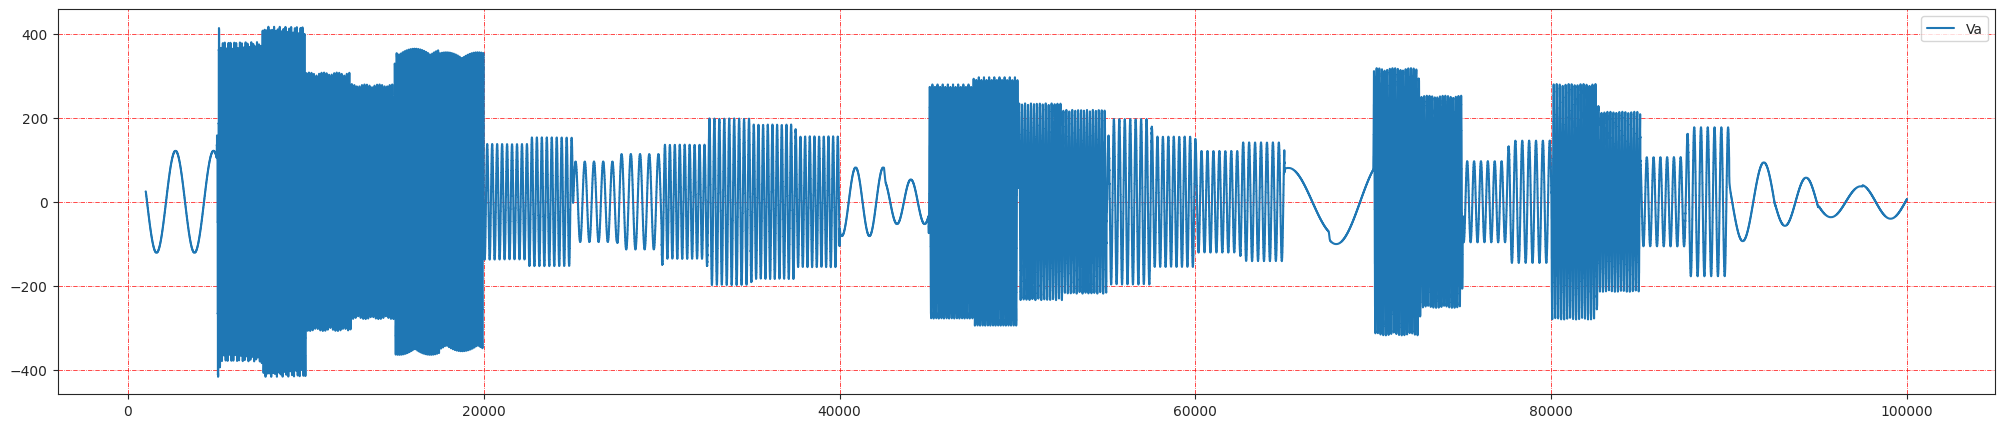

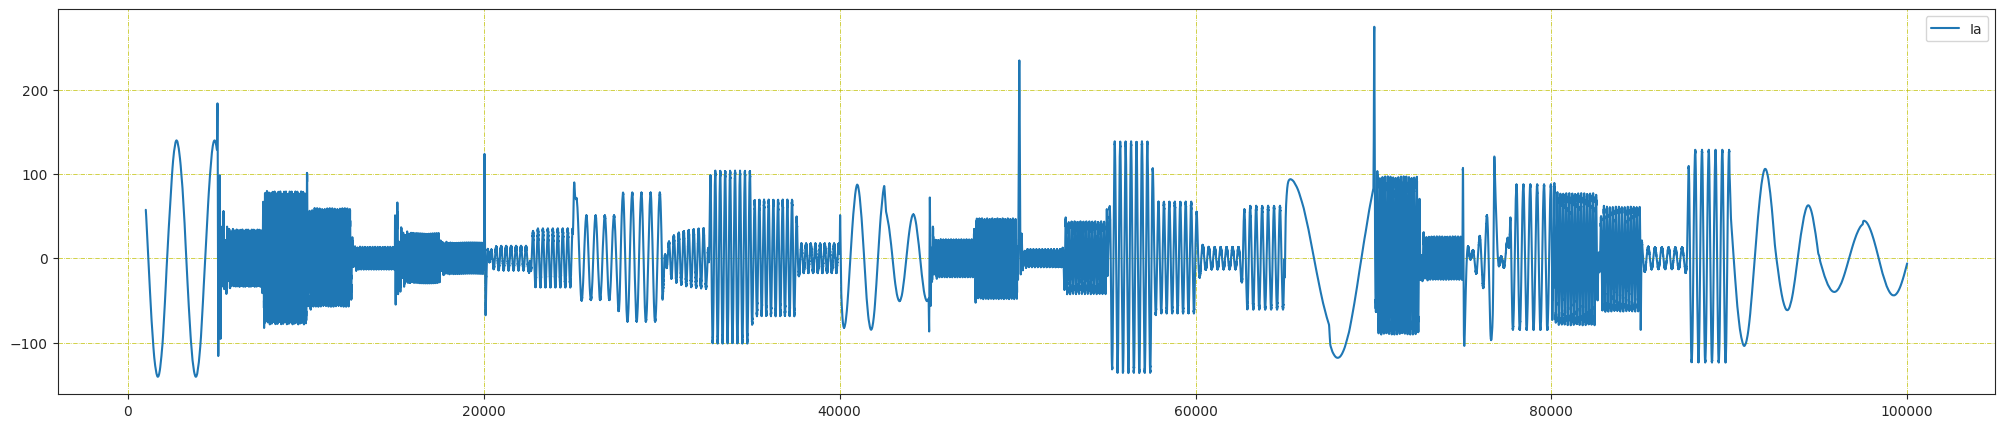

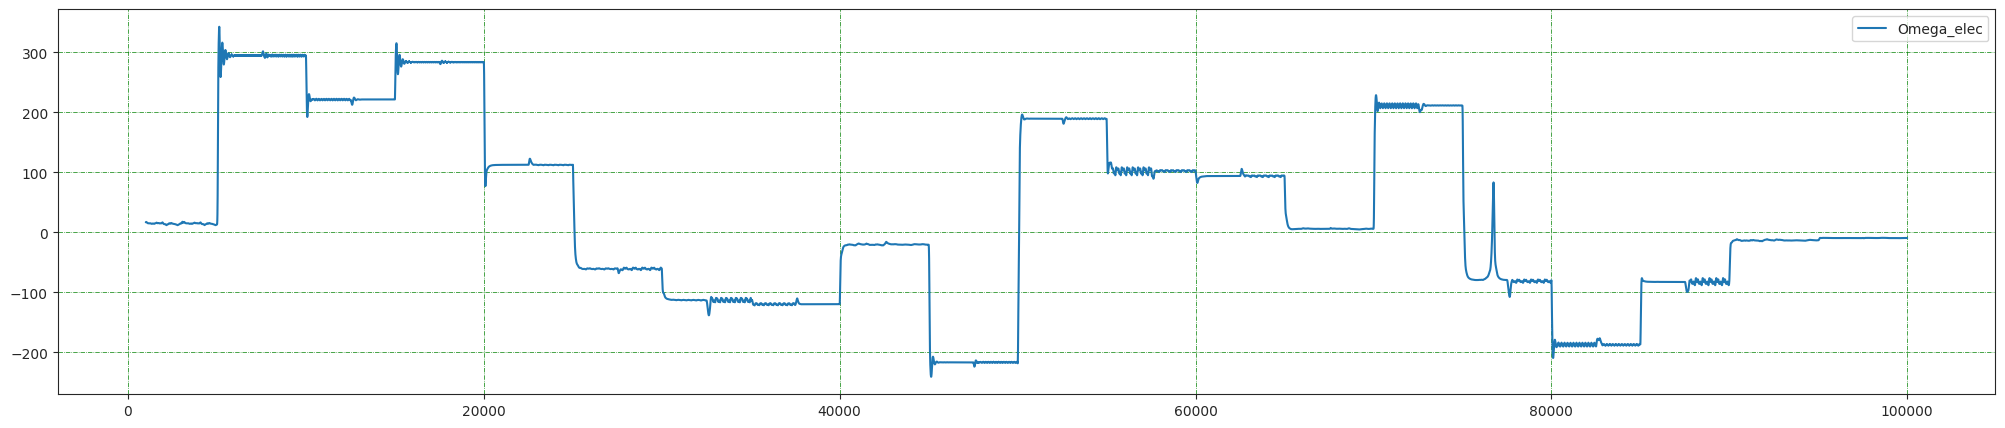

In [236]:
plt.figure(figsize=(25,5))
myData['Va'][1000:100000].plot(legend=True)
plt.grid(color='r', linestyle='-.', linewidth=0.5)
plt.show()

plt.figure(figsize=(25,5))
myData['Ia'][1000:100000].plot(legend=True)
plt.grid(color='y', linestyle='-.', linewidth=0.5)
plt.show()

plt.figure(figsize=(25,5))
myData['Omega_elec'][1000:100000].plot(legend=True)
plt.grid(color='g', linestyle='-.', linewidth=0.5)
plt.show()

### Input - Output Feature Selection

In [237]:
input_names = ['Va','Ia','Omega_elec']
target_names =  ['Va','Ia','Omega_elec']

### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [238]:
x_data = myData[input_names].values.astype(np.float32, casting='unsafe')
x_data

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -1.3680e-09,  4.2134e-02],
       [ 0.0000e+00, -1.2248e-07,  1.7730e-01],
       ...,
       [ 4.7621e+01, -2.0900e+01, -4.7053e+01],
       [ 4.7621e+01, -1.9935e+01, -4.7008e+01],
       [ 5.0142e+01, -1.9092e+01, -4.6958e+01]], dtype=float32)

### Input Data Characteristics

In [239]:
print("X-data Type:", type(x_data))
print("X-data Dtype:", x_data.dtype)
print("X-data Shape:", x_data.shape)
print("X-data Infinite values:", np.isinf(x_data).any())
print("X-data NaN values:", np.isnan(x_data).any())

X-data Type: <class 'numpy.ndarray'>
X-data Dtype: float32
X-data Shape: (500002, 3)
X-data Infinite values: False
X-data NaN values: False


These are the output-signals (or target-signals):

In [240]:
y_data = myData[target_names].values.astype(np.float32, casting='unsafe')
y_data

array([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
       [ 0.0000e+00, -1.3680e-09,  4.2134e-02],
       [ 0.0000e+00, -1.2248e-07,  1.7730e-01],
       ...,
       [ 4.7621e+01, -2.0900e+01, -4.7053e+01],
       [ 4.7621e+01, -1.9935e+01, -4.7008e+01],
       [ 5.0142e+01, -1.9092e+01, -4.6958e+01]], dtype=float32)

### Target Data Characteristics

In [241]:
print("Y-data Type:", type(y_data))
print("Y-data Dtype:", y_data.dtype)
print("Y-data Shape:", y_data.shape)
print("Y-data Infinite values:", np.isinf(y_data).any())
print("Y-data NaN values:", np.isnan(y_data).any())

Y-data Type: <class 'numpy.ndarray'>
Y-data Dtype: float32
Y-data Shape: (500002, 3)
Y-data Infinite values: False
Y-data NaN values: False


This is the number of observations (aka. data-points or samples) in the data-set:

In [242]:
num_data = len(x_data)
num_data

500002

### Define training, validation and testing sample size

In [243]:
batch_size = 32
sequence_length = 100
train_split = 0.9
num_train = int(train_split * num_data)
num_val = int(0.5*(num_data - num_train))
num_test = (num_data - num_train) - num_val
steps_per_epoch = int((num_train/batch_size)/40)
train_validation_steps = int((num_val/batch_size))
test_validation_steps = int((num_test/batch_size))
test_validation_steps = 1
print('num_train:',num_train, 'num_val:',num_val, 'num_test:',num_test)
print('steps_per_epoch:', steps_per_epoch)
print('train_validation_steps:', train_validation_steps, 'test_validation_steps:', test_validation_steps)

num_train: 450001 num_val: 25000 num_test: 25001
steps_per_epoch: 351
train_validation_steps: 781 test_validation_steps: 1


In [244]:
y_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(y_data)
x_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(x_data)

In [245]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=train_split, random_state=None, shuffle=False )
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (450001, 3)
y_train shape: (450001, 3)
x_test shape: (50001, 3)
y_test shape: (50001, 3)


This is the number of observations in the training-set:

In [246]:
num_train = len(x_train)
num_train

450001

This is the number of observations in the test-set:

In [247]:
num_test = len(x_test)
num_test

50001

These is the total number of input observations for the training and test sets:

In [248]:
len(x_train) + len(x_test)

500002

These is the total number of output observations for the training and test sets:

In [249]:
len(y_train) + len(y_test)

500002

This is the number of input features:

In [250]:
num_x_signals = x_data.shape[1]
num_x_signals

3

This is the number of target features:

In [251]:
num_y_signals = y_data.shape[1]
num_y_signals

3

### Check Data Magnitudes

The data-set contains a wide range of values:

In [252]:
print('x_train min:', x_train.min())
print('x_train max:', x_train.max())

print('y_train min:', y_train.min())
print('y_train max:', y_train.max())

print('x_test min:', x_test.min())
print('x_test max:', x_test.max())

print('y_test min:', y_test.min())
print('y_test max:', y_test.max())

x_train min: -631.54
x_train max: 631.56
y_train min: -631.54
y_train max: 631.56
x_test min: -772.93
x_test max: 772.98
y_test min: -772.93
y_test max: 772.98


## Create Noise Generator

In [255]:
class NoiseGenerator(nn.Module):
    def __init__(self):
        super(NoiseGenerator, self).__init__()

    def forward(self, signal, snr_db):
        signal_power = torch.mean(signal ** 2)
        snr = 10 ** (snr_db / 10)
        noise_power = signal_power / snr
        noise = torch.randn_like(signal) * torch.sqrt(noise_power)
        return noise

noise_gen = NoiseGenerator()
noise_gen(torch.Tensor(x_train), snr_db=20)

tensor([[ 10.4990,   4.2011,  -6.6323],
        [ -4.4824,  -5.5257,  29.0793],
        [-14.5677, -25.3218,  -1.3927],
        ...,
        [-22.3956,  40.5072,  17.9457],
        [  6.8222,   2.8356,  -9.9091],
        [ 10.6517,   9.0248,  -7.5223]])

## Check Train and Test Set Distribution


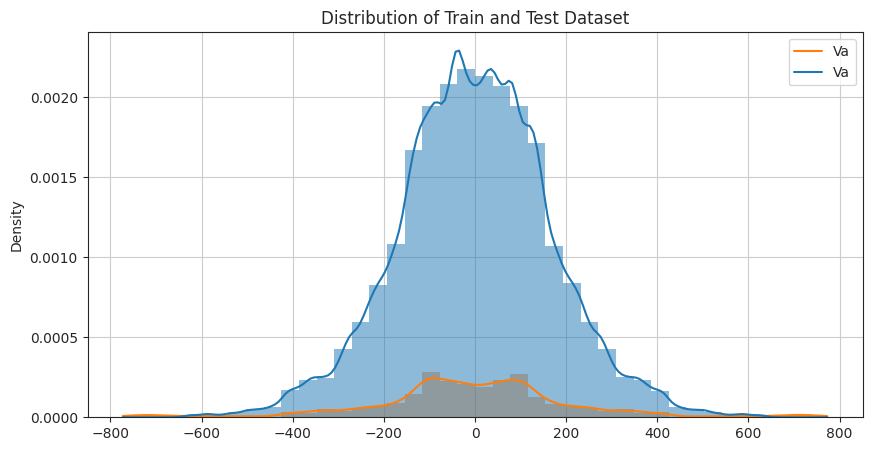

In [256]:
plt.figure(figsize=(10,5))
sns.histplot([y_train[:,0],y_test[:,0]], bins=40, kde=True, stat="density", linewidth=0, edgecolor='black')
plt.legend([target_names[0], target_names[0]])
plt.title('Distribution of Train and Test Dataset')
plt.grid(True)
plt.show()

## Custom Tensorflow Data Generator 

The data-set has now been prepared as 2-dimensional numpy arrays. 

These are the array-shapes of the input and output data:

In [257]:

class PMSMSignals(Dataset):
    def __init__(self, mode='Train', train_split=0.9, test_split=0.5, sequence_length=sequence_length, random_SNR=True, SNR_dB=25):

        myData = pd.read_csv(os.path.join(DATASET_FOLDER, PMSM_DATA))
        self.sequence_length = sequence_length
        self.mode = mode
        self.random_SNR = random_SNR
        self.SNR_dB = SNR_dB

        input_names = ['Ia']
        target_names =  ['Ia']

        x_train, x_test, y_train, y_test = train_test_split(myData[input_names].values.astype(np.float32, casting='unsafe'), 
                                                            myData[target_names].values.astype(np.float32, casting='unsafe'), 
                                                            train_size=train_split, random_state=None, shuffle=False)

        print('x_train shape:', x_train.shape)
        print('y_train shape:', y_train.shape)
        print('x_test shape:', x_test.shape)
        print('y_test shape:', y_test.shape)        

        if mode=='Train':
            # print('using train samples')
            self.x_samples = torch.Tensor(x_train) 
            self.y_samples = torch.Tensor(y_train) 

        elif mode=='Test':
            # print('using test samples')
            self.x_samples = torch.Tensor(x_test)
            self.y_samples = torch.Tensor(y_test)
            
        self.n = len(self.x_samples)-self.sequence_length
        print(self.n)

        

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        
        # Allocate a new array for the batch of input-signals.
        # if self.mode=='Train' : #or self.validation
        #     sequence_length_ = np.random.randint(1,self.sequence_length)
        # else:
        #     sequence_length_ = self.sequence_length
        #     # print(f"Sequence_length: {sequence_length_}")

        x_shape = (self.sequence_length, self.x_samples.shape[-1])
        x_noised_batch = torch.zeros(shape=x_shape, dtype=torch.float32)  
        x_clean_batch = torch.zeros(shape=x_shape, dtype=torch.float32)  

        if self.random_SNR:
            input_SNR = torch.random.randint(20,self.SNR_dB)
        else:
            input_SNR = self.SNR_dB

        # Get a random start-index.
        # idx = np.random.randint(self.n - sequence_length_)
        target_SNR = torch.random.randint(self.SNR_dB, 30)

        # Inputs
        x_clean_batch[:, :self.x_samples.shape[-1]] = self.x_samples[idx:idx+self.sequence_length].reshape(-1,self.x_samples.shape[-1]) 

        # Outputs
        x_noised_batch[:, :self.x_samples.shape[-1]] = x_clean_batch[:, :self.x_samples.shape[-1]] #+ noise_gen(torch.Tensor(x_clean_batch[:self.sequence_length, :self.x_samples.shape[-1]]), snr_db=input_SNR)
        return (x_noised_batch, torch.Tensor([input_SNR, target_SNR])), x_clean_batch


In [258]:
from torch.utils.data import Dataset, DataLoader
class PMSMSignals(Dataset):
    def __init__(self, mode='Train', train_split=0.9, test_split=0.5, sequence_length=100, random_SNR=True, SNR_dB=25):

        myData = pd.read_csv(os.path.join(DATASET_FOLDER, PMSM_DATA))
        self.sequence_length = sequence_length
        self.mode = mode
        self.random_SNR = random_SNR
        self.SNR_dB = SNR_dB

        input_names = ['Ia']
        target_names =  ['Ia']

        x_train, x_test, y_train, y_test = train_test_split(myData[input_names].values.astype(np.float32, casting='unsafe'), 
                                                            myData[target_names].values.astype(np.float32, casting='unsafe'), 
                                                            train_size=train_split, random_state=None, shuffle=False)

        print('x_train shape:', x_train.shape)
        print('y_train shape:', y_train.shape)
        print('x_test shape:', x_test.shape)
        print('y_test shape:', y_test.shape)        

        if mode=='Train':
            # print('using train samples')
            self.x_samples = x_train 
            self.y_samples = y_train 
            self.n = self.x_samples.shape[0]-self.sequence_length

        elif mode=='Test':
            # print('using test samples')
            self.x_samples = x_test
            self.y_samples = y_test
            self.n = self.x_samples.shape[0]-self.sequence_length

        

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        
        # Allocate a new array for the batch of input-signals.
        # if self.mode=='Train' : #or self.validation
        #     sequence_length_ = np.random.randint(1,self.sequence_length)
        # else:
        #     sequence_length_ = self.sequence_length
        #     # print(f"Sequence_length: {sequence_length_}")

        x_shape = (self.sequence_length, self.x_samples.shape[-1])
        x_noised_batch = np.zeros(shape=x_shape, dtype=np.float32)  
        x_clean_batch = np.zeros(shape=x_shape, dtype=np.float32)  

        if self.random_SNR:
            input_SNR = np.random.randint(20,self.SNR_dB)
        else:
            input_SNR = self.SNR_dB

        # Get a random start-index.
        # idx = np.random.randint(self.n - sequence_length_)
        target_SNR = np.random.randint(self.SNR_dB, 30)

        # Inputs
        x_clean_batch[:, :self.x_samples.shape[-1]] = self.x_samples[idx:idx+self.sequence_length].reshape(-1,self.x_samples.shape[-1]) 

        # Outputs
        x_noised_batch[:, :self.x_samples.shape[-1]] = torch.Tensor(x_clean_batch[:, :self.x_samples.shape[-1]]) + noise_gen(torch.Tensor(x_clean_batch[:self.sequence_length, :self.x_samples.shape[-1]]), snr_db=input_SNR)
        return (x_noised_batch, np.array([input_SNR])), x_clean_batch


In [259]:
dataset_train = PMSMSignals(mode='Train')
dataset_test = PMSMSignals(mode='Test')

type(dataset_train), type(dataset_test)

x_train shape: (450001, 1)
y_train shape: (450001, 1)
x_test shape: (50001, 1)
y_test shape: (50001, 1)
x_train shape: (450001, 1)
y_train shape: (450001, 1)
x_test shape: (50001, 1)
y_test shape: (50001, 1)


(__main__.PMSMSignals, __main__.PMSMSignals)

In [260]:
# Load dataset as tensors
dataloader_train = DataLoader(dataset_train,
                        batch_size=32,
                        shuffle=True)

dataloader_test = DataLoader(dataset_test,
                        batch_size=32,
                        shuffle=True)

example=next(iter(dataloader_train))
example[0][0].shape

torch.Size([32, 100, 1])

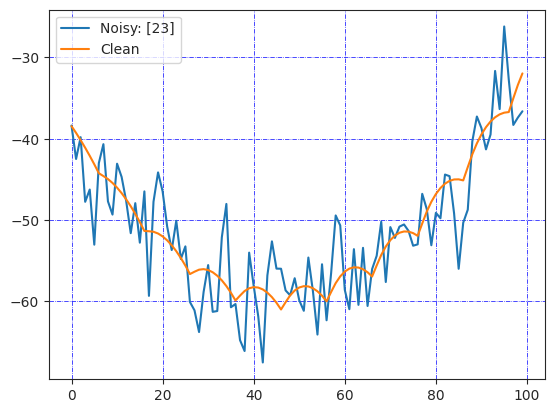

In [261]:
batch = 0   # First sequence in the batch.
signal_ = 0  # First signal from the 20 input-signals.
seq = example[0][0][batch, :, signal_]
seqSNR = example[0][1][batch]
# plt.figure(figsize=(15,5))
plt.plot(seq)
seq = example[1][batch, :, signal_]
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.plot(seq)
plt.legend([f'Noisy: {seqSNR.numpy()}', 'Clean'])

## Implement Custom Metrics

In [262]:
class SNR_metric(torch.nn.Module):
    def __init__(self):
        super(SNR_metric, self).__init__()
        self.to(torch.device("cuda:0"))

    def forward(self, y_true, y_pred):
        signal_power = torch.mean(torch.pow(y_pred, 2))
        noise_power = torch.mean(torch.pow(torch.abs(y_pred) - torch.abs(y_true), 2))
        noise_power = torch.clamp(noise_power, min=1e-10) # handling zero division
        SNR_p = torch.div(signal_power, noise_power)
        SNR_p_DB = torch.mul(torch.log10(SNR_p), 10)
        return torch.mean(SNR_p_DB)

class PSNR(nn.Module):
    def __init__(self, max_val=100):
        super(PSNR, self).__init__()
        self.to(torch.device("cuda:0"))

    def forward(self, y_true, y_pred):
        self.max_val = y_true.max()
        mse = torch.mean((y_true - y_pred) ** 2)
        psnr = 10 * torch.log10(self.max_val ** 2 / mse)
        return psnr

class SSIM(nn.Module):
    def __init__(self, window_size=11, size_average=True):
        self.to(torch.device("cuda:0"))
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.c1 = (0.01 * 255) ** 2
        self.c2 = (0.03 * 255) ** 2

    def _ssim(self, x, y):
        C1 = self.c1
        C2 = self.c2

        window = torch.ones(1, 1, self.window_size, self.window_size)

        mu_x = torch.nn.functional.conv2d(x, window, padding=self.window_size // 2)
        mu_y = torch.nn.functional.conv2d(y, window, padding=self.window_size // 2)

        sigma_x = torch.nn.functional.conv2d(x * x, window, padding=self.window_size // 2) - mu_x ** 2
        sigma_y = torch.nn.functional.conv2d(y * y, window, padding=self.window_size // 2) - mu_y ** 2
        sigma_xy = torch.nn.functional.conv2d(x * y, window, padding=self.window_size // 2) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)

        SSIM = SSIM_n / SSIM_d

        if self.size_average:
            return torch.mean(SSIM)
        else:
            return torch.mean(torch.mean(SSIM, 3), 2)
    
    def forward(self, y_true, y_pred):
        y_true = y_true.permute(0, 2, 1)
        y_pred = y_pred.permute(0, 2, 1)
        y_true = y_true.view(y_true.shape[0],1,y_true.shape[1],y_true.shape[2])
        y_pred = y_pred.view(y_pred.shape[0],1,y_pred.shape[1],y_pred.shape[2])
        ssim = self._ssim(y_true, y_pred)
        return ssim

In [292]:
class Generator(nn.Module):
    def __init__(self, input_features=sequence_length*1, extra_values=1):
        super(Generator, self).__init__()
        self.to(torch.device("cuda:0"))

        
        self.input_features = input_features
        self.extra_values = extra_values

        # Encoder layers
        self.fc1 = nn.Linear(input_features, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.silu = nn.SiLU()
        self.dropout = nn.Dropout(0.5)
        
        # Latent space
        self.latent_size = 256 + extra_values

        # Decoder layers
        self.fc_decoder1 = nn.Linear(self.latent_size, 512)
        self.fc_decoder2 = nn.Linear(512, 1024)
        self.fc_decoder3 = nn.Linear(1024, input_features)
        self.batch_norm_decoder1 = nn.BatchNorm1d(512)
        self.batch_norm_decoder2 = nn.BatchNorm1d(1024)

    def forward(self, x, extra_vals):
        x = x.view(x.shape[0], -1)
        x = self.batch_norm1(self.silu(self.fc1(x))) # Pass through first fully connected layer
        x = self.dropout(x) # Apply dropout
        
        x = self.batch_norm2(self.silu(self.fc2(x))) # Pass through second fully connected layer
        x = self.dropout(x) # Apply dropout
        
        x = self.batch_norm3(self.silu(self.fc3(x))) # Pass through third fully connected
        x = self.dropout(x) # Apply dropout

        # Concatenate the extra values with the output from the fully connected layer
        x = torch.cat((x, extra_vals), dim=1)
        
        x = self.batch_norm_decoder1(self.silu(self.fc_decoder1(x))) # Pass through first fully connected layer in the decoder
        x = self.batch_norm_decoder2(self.silu(self.fc_decoder2(x))) # Pass through second fully connected layer in the decoder
        x = self.fc_decoder3(x) # Pass through third fully connected layer in the decoder and apply sigmoid activation function
        x = x.view(x.shape[0], -1, 1)

        return x


In [293]:
class Discriminator(nn.Module):
    def __init__(self, input_features=sequence_length*1):
        super(Discriminator, self).__init__()
        self.to(torch.device("cuda:0"))
        
        self.input_features = input_features

        # Encoder layers
        self.fc1 = nn.Linear(input_features, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.silu = nn.SiLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.5)
        
        # Decoder layers
        self.fc_output = nn.Linear(256, 1)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.batch_norm1(self.silu(self.fc1(x))) # Pass through first fully connected layer
        x = self.dropout(x) # Apply dropout
        
        x = self.batch_norm2(self.silu(self.fc2(x))) # Pass through second fully connected layer
        x = self.dropout(x) # Apply dropout
        
        x = self.batch_norm3(self.silu(self.fc3(x))) # Pass through third fully connected
        x = self.dropout(x) # Apply dropout
        x1 = self.sigmoid(self.fc_output(x)) 

        x2 = self.silu(self.fc_output(x)) 
        
        x = torch.cat((x1, x2), dim=1)

        return x


In [318]:
# Set your parameters
criterion = nn.BCEWithLogitsLoss()
SNR_loss=SNR_metric()
MSE_loss=nn.MSELoss()
PSNR_loss=PSNR()
n_epochs = 500
display_step = 2000
lr = 0.01


device = 'cpu'
gen = Generator().to(device) # build a Generator Model from the Generator class
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr) # define an Adam optimizer for the Generator
disc = Discriminator().to(device) # build a Discriminator Model from the Discriminator class
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr) # define an Adam optimizer for the Discriminator

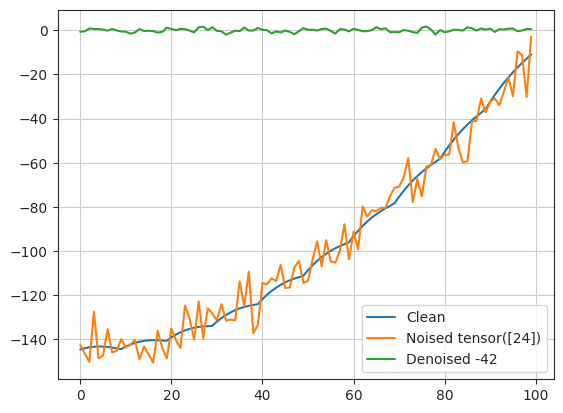

In [319]:
data_test = next(iter(dataloader_test))

noisy_test = data_test[0][0]
seqSNR_test = data_test[0][1]
real_test = data_test[1]
fake_test = gen(noisy_test, seqSNR_test).detach()
snr_loss = SNR_loss(real_test[0],fake_test[0])


plt.plot(real_test[0], label='Clean')
plt.plot(noisy_test[0], label=f'Noised {seqSNR_test[0]}')
plt.plot(fake_test[0], label=f'Denoised {int(snr_loss)}')
# plt.title(f'Target SNR = {seqSNR_test[0][1]}, MSE = {mse_loss}')
plt.legend()

In [320]:
def compute_losses(gen, seqSNR, disc, criterion, real, noisy, device):

    denoised_signal = gen(noisy, seqSNR) # generate a batch (num_images) of fake images.

    disc_fake_pred = disc(denoised_signal.detach()) # Get the discriminator's prediction of the fake images
    disc_real_pred = disc(real) # Get the discriminator's prediction of the real images

    disc_fake_loss = criterion(disc_fake_pred[:,0], torch.zeros_like(disc_fake_pred[:,0])) # calculate the loss - the labels are all zero (i.e. fake) so we can just build them in the loss function 
    disc_real_loss = criterion(disc_real_pred[:,0], torch.ones_like(disc_real_pred[:,0])) # calculate the loss - the labels are all one (i.e. real) so we can just build them in the loss function

    disc_fake_SNR_loss = torch.abs(disc_fake_pred[:,1] - SNR_loss(real_test, denoised_signal))/30
    disc_real_SNR_loss = torch.abs(disc_real_pred[:,1] - SNR_loss(real_test, real_test))/30
    
    gen_denoised_SNR_loss = SNR_loss(real_test, denoised_signal)

    disc_loss = 0.5*(disc_fake_loss + disc_real_loss) + 0.5*(disc_fake_SNR_loss + disc_real_SNR_loss) #+ seqSNR[:,1]# Calculate the discriminator's loss by averaging the real and fake loss and set it to disc_loss.4
    
    gen_loss = 100*criterion(disc_fake_pred, torch.ones_like(disc_fake_pred)) + -SNR_loss(real, denoised_signal) + MSE_loss(real, denoised_signal) # Calculate the generator's loss - the generator wants the discriminator to think that its fake images are real i.e. the labels have to be one
    

    return disc_loss.mean(), gen_loss.mean()

Loop 1:   0%|          | 0/14060 [00:00<?, ?it/s]

Epoch 0.00, step 2000.00: Generator loss: 254.32, discriminator loss: 3.13


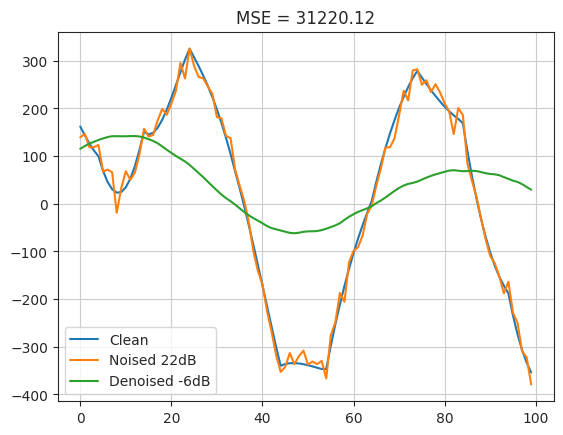

Epoch 0.00, step 4000.00: Generator loss: 242.26, discriminator loss: 3.15


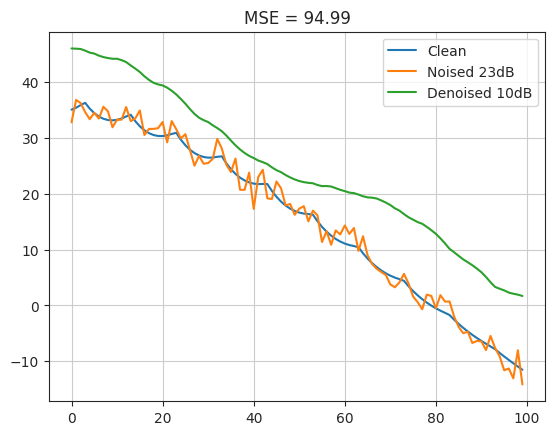

Epoch 0.00, step 6000.00: Generator loss: 231.04, discriminator loss: 3.18


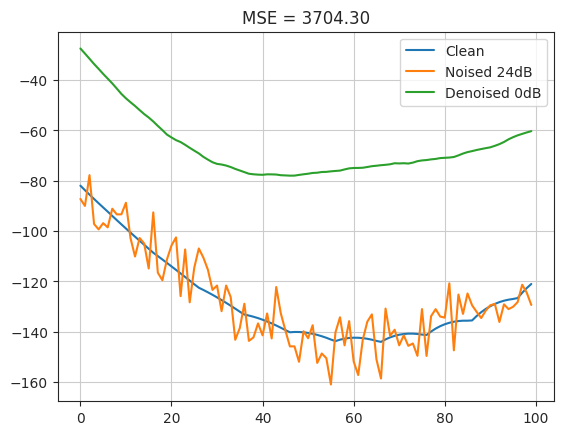

Epoch 0.00, step 8000.00: Generator loss: 223.46, discriminator loss: 3.24


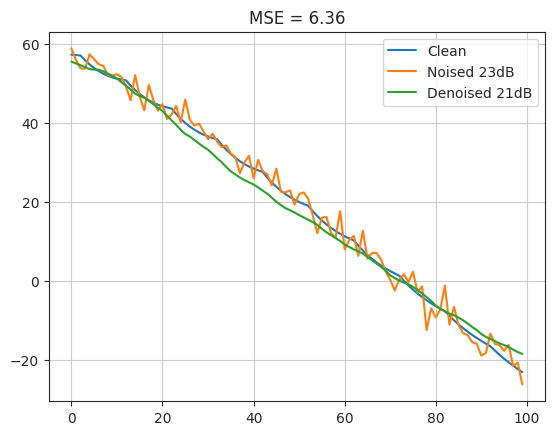

Epoch 0.00, step 10000.00: Generator loss: 223.45, discriminator loss: 3.23


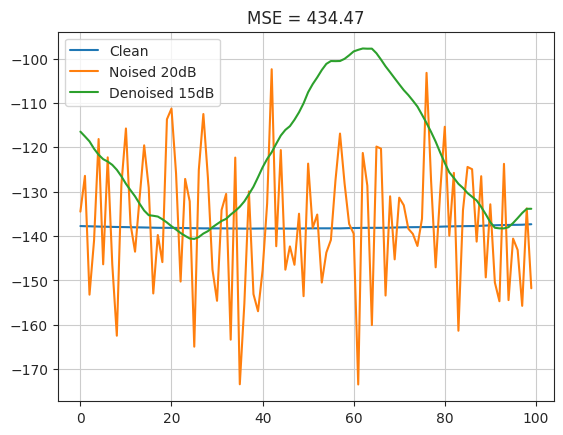

Epoch 0.00, step 12000.00: Generator loss: 212.58, discriminator loss: 3.11


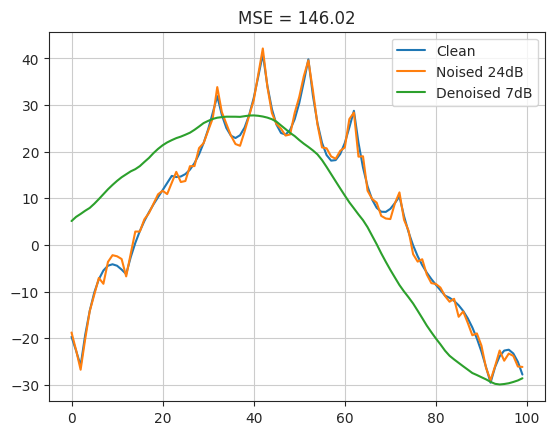

Epoch 0.00, step 14000.00: Generator loss: 211.74, discriminator loss: 3.21


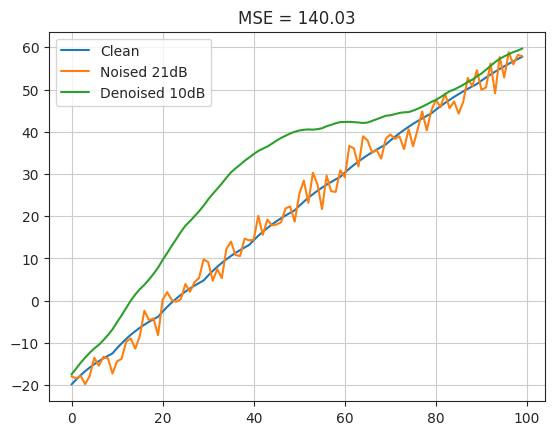

RuntimeError: The size of tensor a (13) must match the size of tensor b (32) at non-singleton dimension 0

In [327]:
from tqdm.notebook import tqdm_notebook

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False
error = False

##Training starts here!!!
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    
    for data in tqdm_notebook(dataloader_train, desc='Loop 1'):

        noisy_train = data[0][0]
        seqSNR_train = data[0][1]
        real_train = data[1]

        cur_batch_size = len(real_train)

        ### Update discriminator and generator ###

        # Calculate discriminator loss
        disc_loss, gen_loss = compute_losses(gen, seqSNR_train, disc, criterion, real_train, noisy_train, device)
        # Update gradients
        disc_loss.backward(retain_graph=True)
        gen_loss.backward(retain_graph=True)

        # Update optimizer
        disc_opt.step()
        gen_opt.step()

        # Zero out the gradients for the next pass
        disc_opt.zero_grad()
        gen_opt.zero_grad()
         
        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch:.2f}, step {cur_step:.2f}: Generator loss: {mean_generator_loss:.2f}, discriminator loss: {mean_discriminator_loss:.2f}")
            data_test = next(iter(dataloader_test))
            noisy_test = data_test[0][0]
            seqSNR_test = data_test[0][1]
            real_test = data_test[1]
            fake_test = gen(noisy_test, seqSNR_test).detach()
            snr_loss = SNR_loss(real_test[0],fake_test[0])
            mse_loss = MSE_loss(real_test[0],fake_test[0])
            plt.plot(real_test[0], label='Clean')
            plt.plot(noisy_test[0], label=f'Noised {seqSNR_test[0][0]}dB')
            plt.plot(fake_test[0], label=f'Denoised {int(snr_loss)}dB')
            plt.title(f'MSE = {mse_loss:.2f}')
            plt.legend()
            plt.show()
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        
        cur_step += 1
